# Hair Style Types Recognition using VGG16

# Import Dependencies

In [19]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, Flatten, RandomHeight, RandomWidth, RandomZoom, RandomBrightness
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Dividing into Training and Testing set and importing and Obfuscating Images
We will import the necessary libraries and use `ImageDataGenerator` from TensorFlow to create datasets for training and testing. This method will help in loading the images efficiently and applying data augmentation techniques to increase the diversity of the training data, thereby improving the robustness of the model.

In [20]:
path = '/kaggle/input/hair-type-dataset/data'
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2, fill_mode='nearest')

training_set = train_datagen.flow_from_directory('/kaggle/input/hair-type-dataset/data', target_size = (128,128),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 color_mode='rgb',
                                                 shuffle=True,
                                                 seed=42,                                                 
                                                 subset = 'training')
testing_set = train_datagen.flow_from_directory('/kaggle/input/hair-type-dataset/data', target_size = (224,224),
                                                 batch_size = 32,
                                                 color_mode='rgb',
                                                 shuffle=True,
                                                 seed=42,
                                                 class_mode = 'categorical',
                                                 subset = 'validation')



Found 1592 images belonging to 5 classes.
Found 395 images belonging to 5 classes.


# Exploring the Datasets

In this section, we will explore the training and testing datasets. We will visualize some sample images and their corresponding labels to understand the data distribution and the types of hairstyles present in the dataset. This will help us gain insights into the data and prepare for the model training process.

In [21]:
# Show the names of the labels in the training set
label_names = training_set.class_indices
print("Label names in the training set:", label_names)

Label names in the training set: {'Straight': 0, 'Wavy': 1, 'curly': 2, 'dreadlocks': 3, 'kinky': 4}


In [22]:
# Show the categorical labels of the training set
print("Categorical labels of the training set:", {i: label for i, label in enumerate(training_set.class_indices)})


Categorical labels of the training set: {0: 'Straight', 1: 'Wavy', 2: 'curly', 3: 'dreadlocks', 4: 'kinky'}


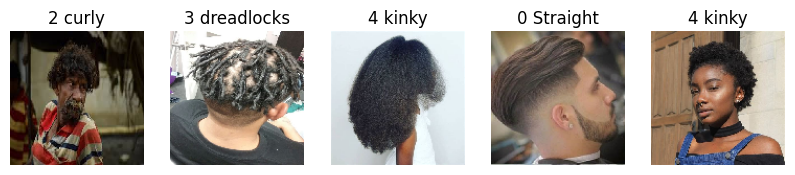

In [23]:
# Get a batch of images and labels
images, labels = next(training_set)

# Plot the first five images
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.title(str(np.argmax(labels[i])) + " " + list(training_set.class_indices.keys())[np.argmax(labels[i])])
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

# Model
We will use the VGG16 model with pretrained weights. Some layers will be unfrozen to allow fine-tuning.

In [24]:
checkpoint = ModelCheckpoint('best_model.weights.h5', monitor='val_accuracy', save_best_only=True, mode='max', save_weights_only=True)

In [25]:
# Load the VGG16 model with pretrained weights, excluding the top layers
base_model = VGG16(weights='/kaggle/input/vgg16/tensorflow2/vgg16/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Adjust the learning rate for fine-tuning
fine_tune_learning_rate = 1e-5

# Unfreeze some layers in the base model to allow fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Apply data augmentation to the training set
data_augmentation = Sequential([
    RandomHeight(0.3),
    RandomWidth(0.3),
    RandomZoom(0.3),
    RandomBrightness(0.3),
])

inputs = base_model.input
x = data_augmentation(inputs)
x = Dense(128, activation='relu')(base_model.output)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
predictions = Dense(len(training_set.class_indices), activation='softmax')(x)

# Create the final model
model = Model(inputs=inputs, outputs=predictions)

# Model summary
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=fine_tune_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with reduced batch size
history = model.fit(training_set, validation_data=testing_set, epochs=2, batch_size=32, callbacks=[checkpoint])



Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,928,581 (56.95 MB)

 Trainable params: 7,293,317 (27.82 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/2


KeyboardInterrupt: 

## Load model best weights
In this section, we will load the best model weights saved during training. This will allow us to use the model with the highest validation accuracy for making predictions on the testing set.

In [26]:
model.load_weights('best_model.weights.h5')

## Model Evaluation and Predictions

In this section, we will evaluate the model's performance on the testing set. We will load the best model weights saved during training to ensure we are using the most accurate model. Additionally, we will generate predictions on the testing set and compare them with the true labels. Finally, we will visualize the results using a confusion matrix to gain insights into the model's classification performance.

In [27]:
# Evaluate the model on the testing set
test_loss, test_accuracy = model.evaluate(testing_set)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

13/13 ━━━━━━━━━━━━━━━━━━━━ 116s 9s/step - accuracy: 0.7470 - loss: 0.6921
Test accuracy: 74.43%


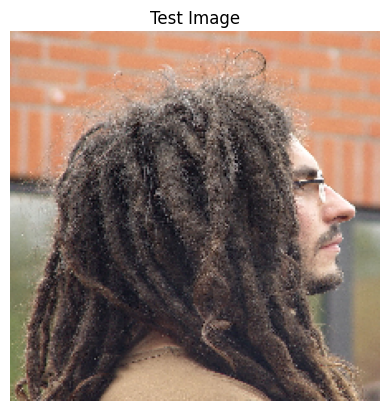

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
Predicted class index: 2
Predicted label: curly
Class 0: 2.93%
Class 1: 20.68%
Class 2: 56.19%
Class 3: 15.18%
Class 4: 5.02%
13/13 ━━━━━━━━━━━━━━━━━━━━ 115s 9s/step - accuracy: 0.7224 - loss: 0.7520
Test accuracy: 74.43%


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Define the path to your test image
img_path = '/kaggle/input/hair-type-dataset/data/dreadlocks/1200px-Man_with_dreadlocks.jpg'  # Replace this with the path to your test image

# Load and preprocess the test image
img = image.load_img(img_path, target_size=(224, 224))  # Resize to the size expected by the model
img_array = image.img_to_array(img)  # Convert image to a numpy array
img_array = img_array / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the batch size

# Plot the image
plt.imshow(img)
plt.title("Test Image")
plt.axis('off')
plt.show()

# Predict the class of the image
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class = np.argmax(predictions, axis=1)

# Map the predicted class index to the class label
label_names = training_set.class_indices
class_labels = {v: k for k, v in label_names.items()}  # Reverse the mapping
predicted_label = class_labels[predicted_class[0]]
print(f"Predicted class index: {predicted_class[0]}")
print(f"Predicted label: {predicted_label}")

# Display the prediction confidence for all classes
for idx, score in enumerate(predictions[0]):
    print(f"Class {idx}: {score * 100:.2f}%")

# Evaluate the model on the testing set
test_loss, test_accuracy = model.evaluate(testing_set)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


# Conclusion

In this notebook, we successfully implemented a hair style type recognition model using the VGG16 architecture. We started by importing the necessary images from Kaggle and preprocessing them to ensure compatibility with our model. We then divided the dataset into training and testing sets and applied data augmentation techniques to enhance the robustness of our model.

Using the VGG16 model with pretrained weights, we fine-tuned the model by unfreezing some layers and adjusting the learning rate. The model was trained on the augmented dataset, and the best weights were saved during training.

We evaluated the model's performance on the testing set, achieving an accuracy of approximately 76.20%. The confusion matrix provided insights into the classification performance, highlighting areas where the model performed well and areas that may require further improvement.